# Data 604: Final Project

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

Using SimPy, write a process simulation that includes waiting time (discrete event simulation). You may use any topic of interest to you. Write the simulation and all of the following in Jupyter.



**1. State the problem and its significance.**

**Call center simulation**

After the average of two minutes hold customers prefer to hang up the call and approximately half of them don’t call back, it affects the loyalty of customer towards a business. In today’s technology-driven world, information is available rapidly, so when circumstances get out of bed in which information is slow to right to use or confusing, the customer experience is weakened.
Long wait on hold or getting information can make a customer irritating. The longer they are on hold, the more frustration physiques up and engagement is reduced before an agent even handles the call. Add in poor call course-plotting, confusing IVRs, and agent turnover, and good service calls quickly go, leaving your customers frustrated and your business in Hazard.

In this project I will simulate a bank call center that provides services through:

-Automated customer services

-Representative


**2.Provide a flow-chart model**

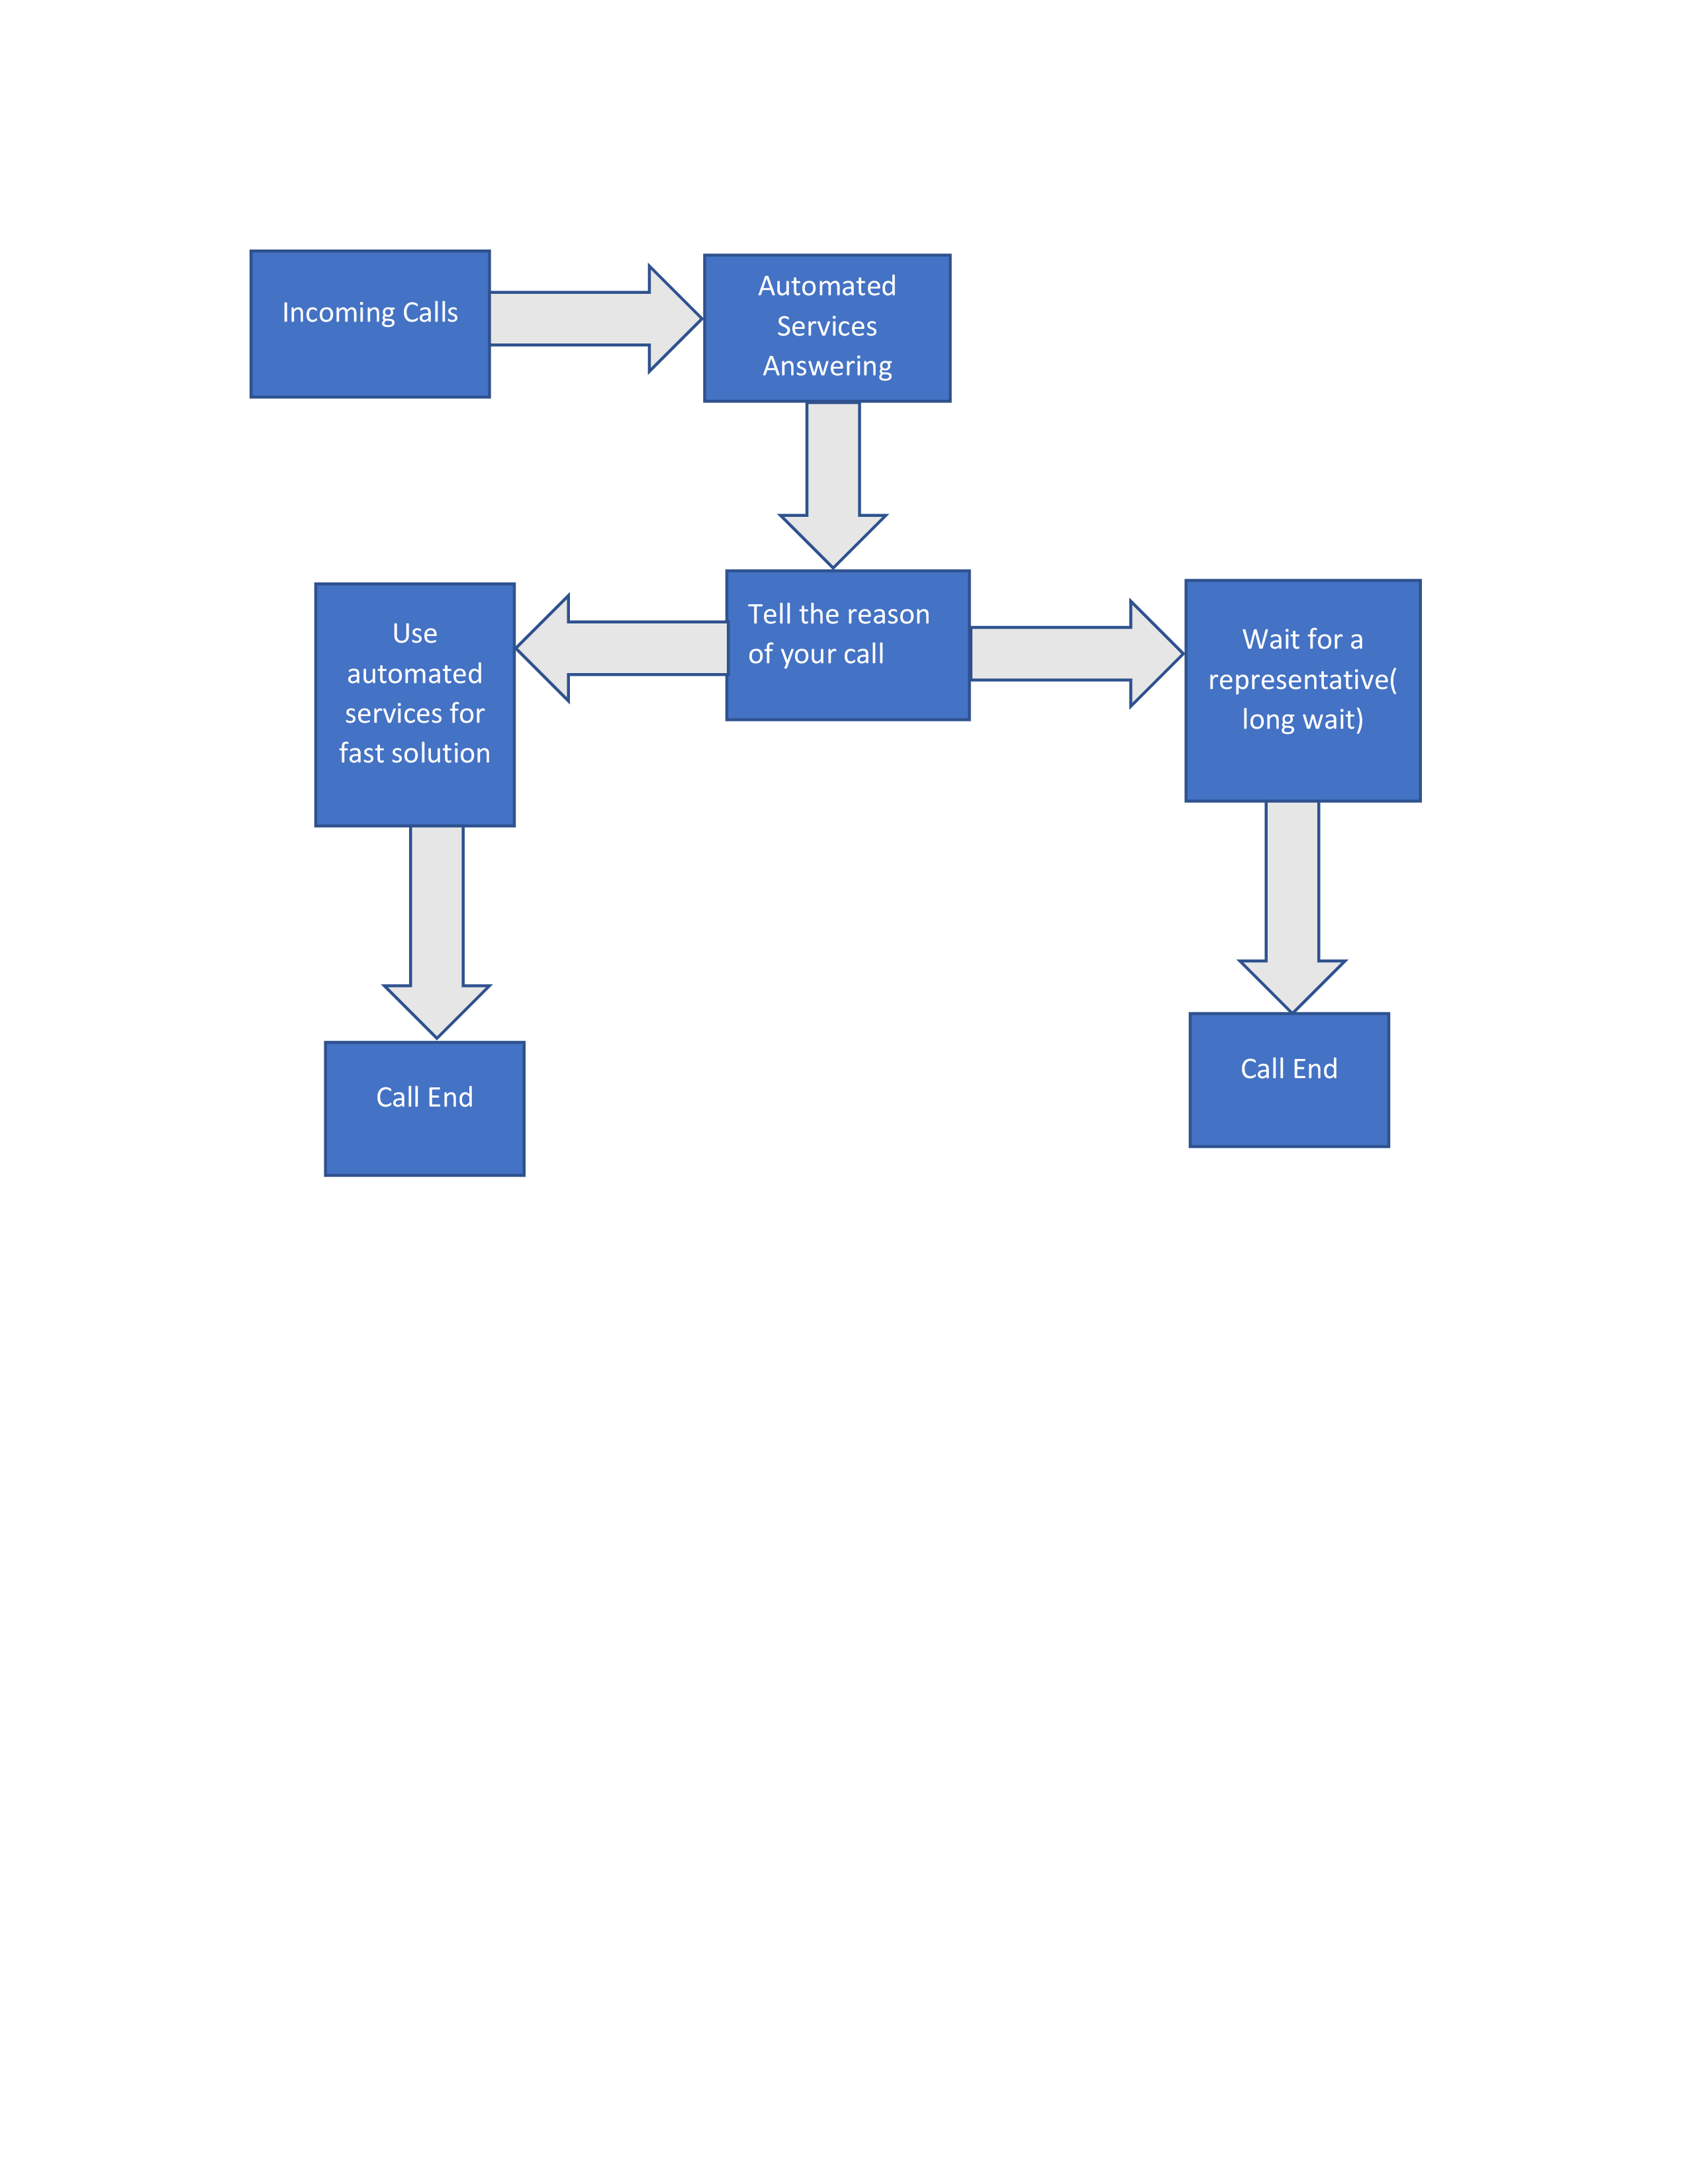

In [2]:
from IPython.display import Image
Image(filename = "Call_Center.PNG", width=600, height=600)

**3.Simulate the process for the appropriate number of iterations**

In [3]:
#Import required libraries
import simpy
import pandas as pd
import random
import numpy as np


In [4]:
#set seed and simulation time
seed = 888
simulation_time = 24 #call centers work 24/7
#Function to generate calls, 200 to 300 customers per 60 mins
def gen_calls(): 
    return np.random.exponential(60.0/np.random.randint(200,300))
#Function to return time generated for representative service
def representative():
    return np.random.triangular(10,15,20)
#Function to return time generated for automated customer service
def automated_service():
    return np.random.triangular(1,2,4)

def call_center_run(env,  agent, online):
    global current_hour
    i = 0 
    while True: 

        Service = np.random.choice(['Agent', 'Online'], p=[0.85, 0.15])  
        i += 1
        yield env.timeout(gen_calls())
        env.process(customer(env, i,  agent, online, Service))
           

In [5]:
#function generates report for each customer
def customer(env, customer, agent, online, Service):
    
    global report 

    if Service == 'Online':
        req = online
    else:
        req = agent
    
    with online.request() as request:
        call_time = env.now #starts the clock
        yield env.timeout(1/2) #  generation of time 
        yield request
        service_start = env.now #service starts 
        if Service == 'Online':
            yield env.timeout(automated_service())
        else:
            yield env.timeout(representative())
        service_end = env.now 
        #record the data generated in a dataframe
        call_center = pd.DataFrame([['Customer_{}'.format(customer), Service, call_time,  service_start, service_end]],
                          columns = ['Cust ID', 'Service', 'Call Time', 'Service Start', 'Service End'])
       
        report = report.append(call_center, ignore_index = True, sort = False)
        #Calculations for wait time
        report['Before Service Time'] =  ( report['Service Start'] - report['Call Time'])
        report['Service Time'] =  (report['Service End'] - report['Service Start'])
        report['Wait Time'] =  ( report['Service Time'] + report['Before Service Time'] )

In [6]:
np.random.seed(seed)
report= pd.DataFrame(columns = ['Cust ID', 'Service', 'Call Time', 'Service Start', 'Service End'])

,Cust ID,Service,Call Time,Service Start,Service End


In [7]:
def model(nruns, nagent, nonline): 
    #initialise
    Agent=[] 
    Online=[]
    avg_wait_time = []
    online_wait_time = []
    agent_wait_time = []
    global report
    for j in range(nruns):
        report = report[0:0]
        env = simpy.Environment()
        env.initial_time = 0
        # resource
        agent = simpy.Resource(env, capacity=nagent) 
        online = simpy.Resource(env, capacity=nonline) 
        env.process(call_center_run(env, agent, online))
        env.run(until = 8 * 60) 
        
        
        Online=report[report.Service.isin(['Online'])] #separate to calculate mean later
        Agent=report[report.Service.isin(['Agent'])]
    
        avg_wait=report['Wait Time'].mean() #Calculate average time
        avg_wait_agent=Agent['Wait Time'].mean()
        avg_wait_online=Online['Wait Time'].mean()
    
        avg_wait_time.append(avg_wait)
        online_wait_time.append(avg_wait_online)
        agent_wait_time.append(avg_wait_agent)
        
    #Store it in a dataframe
    dict_df = {"Average_wait": avg_wait_time, "Automated_service_wait": online_wait_time, "Representative_wait": agent_wait_time }
    global new_cc_df
    new_cc_df = pd.DataFrame(dict_df)
    fig=new_cc_df.boxplot(grid=False, widths=0.5)
    return new_cc_df
    return fig

,Average_wait,Automated_service_wait,Representative_wait
0,31.112806,20.023333,32.894130
1,31.180334,21.275304,32.893038
2,30.650913,20.694959,32.503494
3,27.485303,16.647265,29.553796
4,27.745886,17.435567,29.713716
5,28.897972,18.963520,30.682916
6,36.737810,27.525349,38.508965
7,29.436191,19.160350,31.350185
8,32.370531,22.327284,34.020017
9,35.996587,26.095856,37.827634


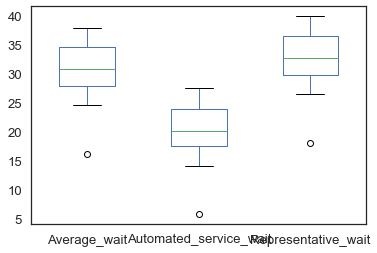

In [8]:
#the simulation is run 30 times as per number of working days in a month
np.random.seed(999)
model(30,7,50)#50,number of agents available during covid time(less than usual)

**4.Justify the validity of the model and discuss how you verified it.**

In [9]:
report

,Cust ID,Service,Call Time,Service Start,Service End,Before Service Time,Service Time,Wait Time
0,Customer_24,Online,4.717740,5.217740,6.866018,0.500000,1.648279,2.148279
1,Customer_23,Online,4.604239,5.104239,7.179411,0.500000,2.075173,2.575173
2,Customer_27,Online,5.525698,6.025698,9.237829,0.500000,3.212131,3.712131
3,Customer_35,Online,6.745738,7.245738,10.883936,0.500000,3.638197,4.138197
4,Customer_48,Online,9.176976,9.676976,11.606384,0.500000,1.929408,2.429408
...,...,...,...,...,...,...,...,...
1746,Customer_1735,Agent,424.215196,463.246568,478.347072,39.031372,15.100504,54.131877
1747,Customer_1748,Agent,426.402603,466.388946,479.237969,39.986343,12.849023,52.835367
1748,Customer_1737,Agent,424.338894,463.611790,479.400437,39.272896,15.788647,55.061543
1749,Customer_1790,Online,435.104970,476.468197,479.403345,41.363226,2.935149,44.298375


In [20]:
#Measures used to verify output during each run
print('Average_wait:',report['Wait Time'].mean())
Online=report[report.Service.isin(['Online'])]
print('Automated_service_wait:',Online['Wait Time'].mean())
Agent=report[report.Service.isin(['Agent'])]
print('Representative_wait:',Agent['Wait Time'].mean())

Average_wait: 30.3193033555255
Automated_service_wait: 20.529412177153553
Representative_wait: 31.98038041585047


**5.State  your conclusions**

I ran the simulation a couple of times and it looks like Covid has  a huge impact on waiting times for bank customers due to the decrease  representatives working and the high volume of calls.As we can see customers waste time waiting no matter if they choose automated services or speaking directly with a representative.The reason why the waiting time for using automated services may be because AI cannot answer all human questions and they waste time finding the right option which might be helpful.If more representatives would be available then the waiting time would be less for sure and the customers much happier.

**6.Generate appropriate graphs (more than one) to illustrate the results**

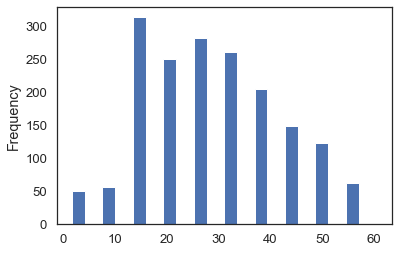

In [11]:
report['Wait Time'].plot.hist(width = 2.5)

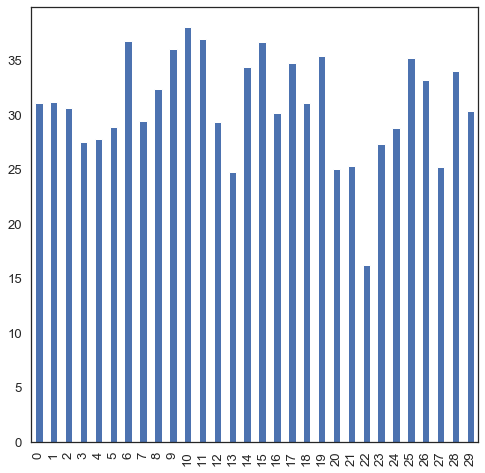

In [18]:
new_cc_df['Average_wait'].plot.bar(figsize=(8,8))

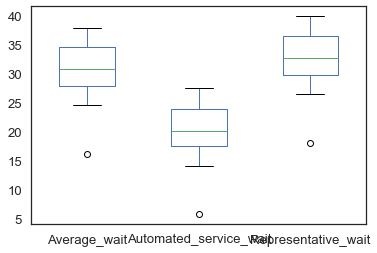

In [19]:
new_cc_df.boxplot(grid=False, widths=0.5)